In [110]:
import torch
from torch import nn
from ultralytics import YOLO
from torchvision import ops
import numpy as np
from torchvision import transforms
from PIL import Image
import cv2

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [111]:
model_ultralytics = YOLO("weights/detect_large.pt")

model_pt = model_ultralytics.model

random_tensor = torch.rand((64, 3, 640, 640)).to(device)
model_pt.to(device)
model_pt.eval();

In [129]:
cap = cv2.VideoCapture("highlight_0.mp4")
ret, orig_img = cap.read()
# transform img to tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])
img = transform(orig_img).unsqueeze(0).to(device)

In [127]:
output = model_ultralytics(orig_img, device=device)
output[0].boxes


0: 416x736 3 basketballs, 1 hoop, 4 persons, 18.9ms
Speed: 19.8ms preprocess, 18.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 736)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 2., 1., 2., 0., 0., 0., 2.], device='cuda:1')
conf: tensor([0.9520, 0.9437, 0.9284, 0.9070, 0.8760, 0.8629, 0.8290, 0.5467], device='cuda:1')
data: tensor([[5.9700e+02, 3.2771e+02, 6.9586e+02, 4.8282e+02, 9.5202e-01, 2.0000e+00],
        [4.4156e+02, 2.8144e+02, 5.3044e+02, 5.0819e+02, 9.4368e-01, 2.0000e+00],
        [4.8756e+02, 1.9457e+02, 5.3653e+02, 2.4806e+02, 9.2840e-01, 1.0000e+00],
        [3.8320e+02, 3.1133e+02, 4.6196e+02, 4.9996e+02, 9.0697e-01, 2.0000e+00],
        [3.0719e+02, 2.7656e+02, 3.4190e+02, 3.0948e+02, 8.7595e-01, 0.0000e+00],
        [7.1438e+02, 4.3411e+02, 7.3573e+02, 4.5518e+02, 8.6291e-01, 0.0000e+00],
        [1.1115e+03, 4.2312e+02, 1.1340e+03, 4.4483e+02, 8.2897e-01, 0.0000e+00],
        [0.0000e+00, 3.3688e+02, 1.0338e+02, 7.2000e+02, 5.4669e-01, 2.0000e+00]], device='cuda:1')
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([8, 6])
xywh: tensor([[ 646.4290,  4

In [66]:
model_pt.to(device);

In [130]:
raw_output = model_pt(img)[0]
raw_output

tensor([[[8.1205e+00, 1.3761e+01, 2.9508e+01,  ..., 5.4233e+02, 5.5997e+02, 5.8381e+02],
         [3.0215e+01, 2.7569e+01, 2.0357e+01,  ..., 5.6504e+02, 5.4187e+02, 5.4041e+02],
         [1.5968e+01, 2.6495e+01, 5.6392e+01,  ..., 1.9589e+02, 1.6143e+02, 1.1407e+02],
         ...,
         [2.7495e-06, 7.5494e-07, 7.0063e-07,  ..., 2.2886e-07, 6.3832e-07, 2.6396e-07],
         [5.7092e-05, 3.3500e-05, 1.1913e-05,  ..., 3.0886e-07, 4.7426e-07, 3.3962e-07],
         [2.2053e-06, 2.0723e-06, 1.3969e-06,  ..., 1.1932e-06, 3.6427e-06, 2.2147e-06]]], device='cuda:1')

In [114]:
def xywh2xyxy(x):
    """
    Convert bounding box coordinates from (x, y, width, height) format to (x1, y1, x2, y2) format where (x1, y1) is the
    top-left corner and (x2, y2) is the bottom-right corner.

    Args:
        x (np.ndarray | torch.Tensor): The input bounding box coordinates in (x, y, width, height) format.

    Returns:
        y (np.ndarray | torch.Tensor): The bounding box coordinates in (x1, y1, x2, y2) format.
    """
    assert x.shape[-1] == 4, f"input shape last dimension expected 4 but input shape is {x.shape}"
    y = torch.empty_like(x) if isinstance(x, torch.Tensor) else np.empty_like(x)  # faster than clone/copy
    dw = x[..., 2] / 2  # half-width
    dh = x[..., 3] / 2  # half-height
    y[..., 0] = x[..., 0] - dw  # top left x
    y[..., 1] = x[..., 1] - dh  # top left y
    y[..., 2] = x[..., 0] + dw  # bottom right x
    y[..., 3] = x[..., 1] + dh  # bottom right y
    return y

def non_max_suppression(
    prediction,
    conf_thres=0.25,
    iou_thres=0.45,
    classes=None,
    agnostic=False,
    max_det=300,
    nc=0,  # number of classes (optional)
    max_nms=30000,
    max_wh=7680,
):
    """
    Perform non-maximum suppression (NMS) on a set of boxes, with support for masks and multiple labels per box.

    Args:
        prediction (torch.Tensor): A tensor of shape (batch_size, num_classes + 4 + num_masks, num_boxes)
            containing the predicted boxes, classes, and masks. The tensor should be in the format
            output by a model, such as YOLO.
        conf_thres (float): The confidence threshold below which boxes will be filtered out.
            Valid values are between 0.0 and 1.0.
        iou_thres (float): The IoU threshold below which boxes will be filtered out during NMS.
            Valid values are between 0.0 and 1.0.
        classes (List[int]): A list of class indices to consider. If None, all classes will be considered.
        agnostic (bool): If True, the model is agnostic to the number of classes, and all
            classes will be considered as one.
        multi_label (bool): If True, each box may have multiple labels.
        labels (List[List[Union[int, float, torch.Tensor]]]): A list of lists, where each inner
            list contains the apriori labels for a given image. The list should be in the format
            output by a dataloader, with each label being a tuple of (class_index, x1, y1, x2, y2).
        max_det (int): The maximum number of boxes to keep after NMS.
        nc (int, optional): The number of classes output by the model. Any indices after this will be considered masks.
        max_time_img (float): The maximum time (seconds) for processing one image.
        max_nms (int): The maximum number of boxes into torchvision.ops.nms().
        max_wh (int): The maximum box width and height in pixels

    Returns:
        (List[torch.Tensor]): A list of length batch_size, where each element is a tensor of
            shape (num_boxes, 6 + num_masks) containing the kept boxes, with columns
            (x1, y1, x2, y2, confidence, class, mask1, mask2, ...).
    """

    # Checks
    assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
    assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"
    if isinstance(prediction, (list, tuple)):  # YOLOv8 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    bs = prediction.shape[0]  # batch size
    nc = nc or (prediction.shape[1] - 4)  # number of classes
    nm = prediction.shape[1] - nc - 4
    xc = prediction[:, 4:].amax(1) > conf_thres  # candidates


    prediction = prediction.transpose(-1, -2)  # shape(1,84,6300) to shape(1,6300,84)

    prediction[..., :4] = xywh2xyxy(prediction[..., :4])  # xywh to xyxy


    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        x = x[xc[xi]]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Detections matrix nx6 (xyxy, conf, cls)
        box, cls, mask = x.split((4, nc, nm), 1)

        conf, j = cls.max(1, keepdim=True)
        x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        if n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        scores = x[:, 4]  # scores

        boxes = x[:, :4] + c  # boxes (offset by class)
        i = ops.nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections
        output[xi] = x[i]

    return output

def clip_boxes(boxes, shape):
    """
    Takes a list of bounding boxes and a shape (height, width) and clips the bounding boxes to the shape.

    Args:
        boxes (torch.Tensor): the bounding boxes to clip
        shape (tuple): the shape of the image

    Returns:
        (torch.Tensor | numpy.ndarray): Clipped boxes
    """
    if isinstance(boxes, torch.Tensor):  # faster individually (WARNING: inplace .clamp_() Apple MPS bug)
        boxes[..., 0] = boxes[..., 0].clamp(0, shape[1])  # x1
        boxes[..., 1] = boxes[..., 1].clamp(0, shape[0])  # y1
        boxes[..., 2] = boxes[..., 2].clamp(0, shape[1])  # x2
        boxes[..., 3] = boxes[..., 3].clamp(0, shape[0])  # y2
    else:  # np.array (faster grouped)
        boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
        boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2
    return boxes


def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None, padding=True, xywh=False):
    """
    Rescales bounding boxes (in the format of xyxy by default) from the shape of the image they were originally
    specified in (img1_shape) to the shape of a different image (img0_shape).

    Args:
        img1_shape (tuple): The shape of the image that the bounding boxes are for, in the format of (height, width).
        boxes (torch.Tensor): the bounding boxes of the objects in the image, in the format of (x1, y1, x2, y2)
        img0_shape (tuple): the shape of the target image, in the format of (height, width).
        ratio_pad (tuple): a tuple of (ratio, pad) for scaling the boxes. If not provided, the ratio and pad will be
            calculated based on the size difference between the two images.
        padding (bool): If True, assuming the boxes is based on image augmented by yolo style. If False then do regular
            rescaling.
        xywh (bool): The box format is xywh or not, default=False.

    Returns:
        boxes (torch.Tensor): The scaled bounding boxes, in the format of (x1, y1, x2, y2)
    """
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (
            round((img1_shape[1] - img0_shape[1] * gain) / 2 - 0.1),
            round((img1_shape[0] - img0_shape[0] * gain) / 2 - 0.1),
        )  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    if padding:
        boxes[..., 0] -= pad[0]  # x padding
        boxes[..., 1] -= pad[1]  # y padding
        if not xywh:
            boxes[..., 2] -= pad[0]  # x padding
            boxes[..., 3] -= pad[1]  # y padding
    boxes[..., :4] /= gain
    return clip_boxes(boxes, img0_shape)

In [131]:
raw_output = model_pt(img)[0]

filtered_output = non_max_suppression(raw_output, iou_thres=0.7)[0]
boxes = filtered_output[:, :4]
scores = filtered_output[:, 4]
classes = filtered_output[:, 5].int()

In [132]:
boxes

tensor([[ 2.4268e+02,  1.7263e+02,  2.6903e+02,  2.1999e+02],
        [ 1.5433e+02,  2.4608e+02,  1.7125e+02,  2.7330e+02],
        [ 1.9255e+02,  2.7898e+02,  2.3587e+02,  4.5219e+02],
        [-4.9149e-02,  2.7827e+02,  3.1725e+01,  6.4331e+02],
        [ 2.2901e+02,  2.4948e+02,  2.6352e+02,  4.5344e+02]], device='cuda:1')

In [124]:
scale_boxes((640, 640), boxes, (640, 640))

tensor([[485.3503,  65.2571, 538.0662, 159.9752],
        [308.6621, 212.1577, 342.4947, 266.5994],
        [385.0928, 277.9594, 471.7365, 624.3778],
        [  0.0000, 276.5469,  63.4506, 640.0000],
        [458.0184, 218.9579, 527.0345, 626.8736]], device='cuda:1')

In [118]:
output[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 0., 2., 2., 2.], device='cuda:1')
conf: tensor([0.9361, 0.8591, 0.8300, 0.7005, 0.2825], device='cuda:1')
data: tensor([[2.4268e+02, 1.7263e+02, 2.6903e+02, 2.1999e+02, 9.3611e-01, 1.0000e+00],
        [1.5433e+02, 2.4608e+02, 1.7125e+02, 2.7330e+02, 8.5905e-01, 0.0000e+00],
        [1.9255e+02, 2.7898e+02, 2.3587e+02, 4.5219e+02, 8.3002e-01, 2.0000e+00],
        [0.0000e+00, 2.7827e+02, 3.1725e+01, 6.4000e+02, 7.0052e-01, 2.0000e+00],
        [2.2901e+02, 2.4948e+02, 2.6352e+02, 4.5344e+02, 2.8247e-01, 2.0000e+00]], device='cuda:1')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([5, 6])
xywh: tensor([[255.8541, 196.3081,  26.3579,  47.3590],
        [162.7892, 259.6893,  16.9163,  27.2208],
        [214.2073, 365.5843,  43.3218, 173.2092],
        [ 15.8627, 459.1367,  31.7253, 361.7266],
        [246.2632, 351.4579,  34.5081, 203.9578]], device='cuda:1')
xywhn: tensor([[0.3998, 0.3067, 0.041

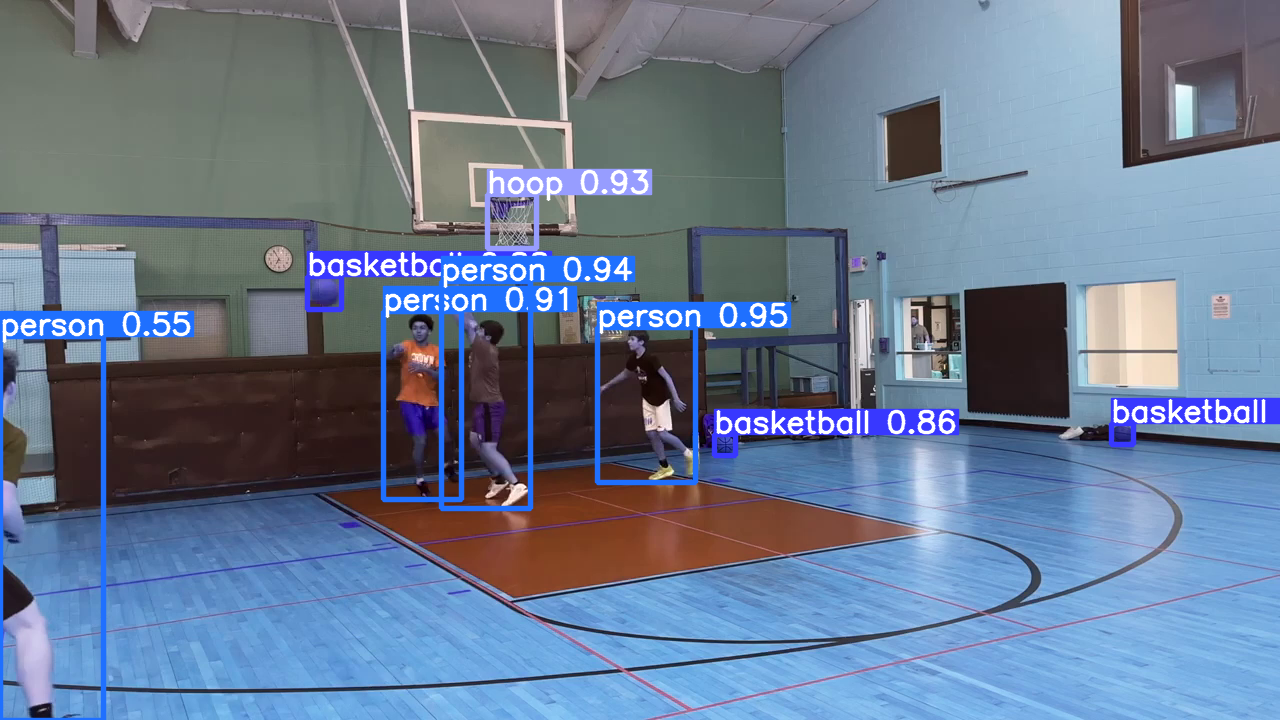

In [133]:
Image.fromarray(output[0].plot())